# はじめに
[統計的因果探索](https://sites.google.com/site/sshimizu06/ksbook)を読んでいる．
この中で，独立成分分析が出てくるが，そういえばあんまり理解できていなかったので，実装して理解する．
日本語の本も見たけど，結局
[Independent Component Analysis: Algorithms and Applications](http://mlsp.cs.cmu.edu/courses/fall2012/lectures/ICA_Hyvarinen.pdf)がわかりやすかった．


# 独立成分分析

確率変数 $\textbf{s} = \{s_1, s_2, ..., s_N\}$ が線形に"mix"された観測 $\bf{x}$ が得られたとき，元の観測をどうにかして復元したい．
独立成分分析では，元の確率変数 $\textbf{s}$の要素が独立であるという仮定から，復元を試みる．

"mix"行列を$A$とすると，

$\textbf{x} = A\textbf{s}$


In [150]:
import pylab as plt
%matplotlib inline

import numpy as np
from scipy import signal

from sklearn.decomposition import PCA

import torch
from torch.autograd import Variable

np.random.seed(0)

n_samples = 5000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal

S = np.c_[s1,  s2]

S /= S.std(axis=0)  # Standardize data
A = np.array([[1, 1], 
              [0.5, 2],
             ])  # Mixing matrix

X = np.dot(S, A.T)  # Generate observations

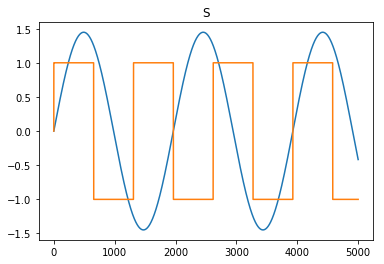

In [151]:
plt.plot(S)
plt.title("S")
plt.show()

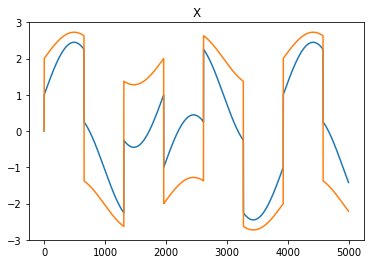

In [152]:
plt.plot(X)
plt.title("X")
plt.show()

独立成分分析では，$\textbf{s}$の各要素が独立であるという仮定から，復元行列 $W$をいい感じに求めて，復元値$\textbf{y} = W\textbf{x}$を決める．

## 中心極限定理を用いる解法

ここで $\textbf{y} = [y_1, y_2]$とすると，

$y_1 = \textbf{w}^\top A \textbf{s}$ ここで，$\textbf{w}$は$W$の行ベクトル

ここで，$\textbf{z}=A\textbf{w}$ とすると
$y_1 = \textbf{z}^\top \textbf{s}$

ここから復元値 $y_1, y_2$ は独立な確率変数$\textbf{s}$を重み付きで足したものであるといえる．

中心極限定理から独立な確率変数の和は"usually"，ガウス分布に近づく．
このため，復元がうまく行っていない場合には，$\textbf{y}$は$\textbf{s}$に比べてガウス分布に近づく．
独立成分分析では，この性質を利用して$\textbf{y}$がよりガウス分布から離れるように$W$を求める．

ガウス分布度合いを測る指標として尖度(kurtosis)がある．
$\textbf{y}$の分散共分散行列が単位行列のとき，

$\mathrm{kurt}(\textbf{y}) = \mathbb{E}[y^4]-3$

尖度はガウス分布に近いときに0となる．
よって，尖度の絶対値を最大化するように$W$を求めることで信号を復元する．

In [153]:
pca = PCA(n_components = X.shape[1], whiten=True)
X = pca.fit_transform(X)

In [155]:
def kurt(Y):
    return torch.mean(Y**4, dim=0) - 3
def kurt_loss(Y):
    # Y の分散共分散が単位行列であることが前提
    return -torch.mean(torch.abs(kurt(Y)))

In [156]:
def ICA(X, loss_func = kurt_loss):
    X = Variable(torch.from_numpy(X), requires_grad =False).float()
    W = Variable((torch.randn((2, 2))), requires_grad =True)
    W.data = W.data / torch.norm(W.data)
    hist_loss = []
    
    for i in range(1000):
        Y = torch.mm(X, W)
        loss = loss_func(Y)
        hist_loss.append(loss.data.numpy())
        loss.backward()

        W.data = W.data - W.grad.data * 0.1
        W.grad.data.zero_()
        W.data = W.data / torch.norm(W.data)
    return Y, W, hist_loss

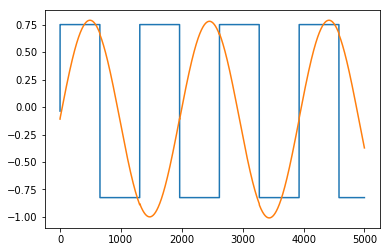

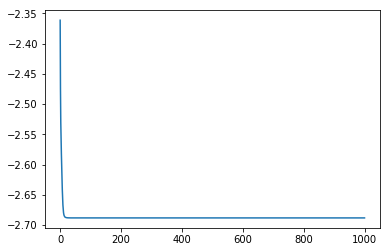

In [157]:
Y, W, hist_loss = ICA(X, loss_func=kurt_loss)
plt.plot(Y.data.numpy())
plt.show()
plt.plot(hist_loss)

いい感じに復元することができた．

# Negentropyを用いた誤差関数

今回はそれなりにうまく復元できたけど，適当に最適化していることもあってうまく収束しないことも多い．
また，尖度は外れ値に対して敏感であることが知られている．
ガウス分布度合いを測る別の指標としてNegentropyがある．

$J(\textbf{y}) = H(\textbf{y}_\mathrm{gauss}) - H(\textbf{y})$

ここで$H$はエントロピー．
ガウス分布はエントロピーが最も高い確率分布であるため，その差を使ってガウス分布度合いを評価する．
しかし，結局，この計算は確率密度関数が必要なので難しい．
そこで，以下のように近似的にNegentropyを求める．

$J(\textbf{y}) \approx \sum _{i=1}^p k_i \{ \mathbb{E} [G_i(y)] - \mathbb{E} [G_i(\nu)] \}^2$

ただし $\nu \sim \mathcal{N}(0,\mathbb{I}), k_i>0 $．
また，$G$には色々な関数が設定できるが，例えば，$G_1(u) = 1/a_1 \log \mathrm{cosh} a_1 u$がある．

In [158]:
def negentropy_loss_logcosh(Y, a=1):
    return -torch.mean(torch.log(torch.cosh(a * Y))/a )**2 

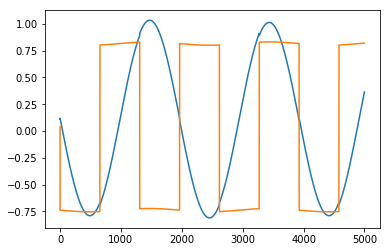

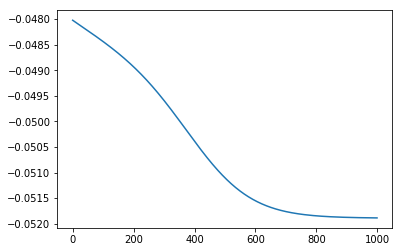

In [159]:
Y, W, hist_loss = ICA(X, loss_func=negentropy_loss_logcosh)
plt.plot(Y.data.numpy())
plt.show()
plt.plot(hist_loss)

# おわりに

独立成分分析の理解のために，自分で実装してみた．
今回は，天下り的に独立とガウス分布らしさの関係について考えたが，論文では同じ最適化問題が相互情報量を最小化するという考えからも導出されている．
また，今回は雑に最適化問題を解いたが，FastICAでは不動点反復法(?)で最適化するらしい．

# 補足

In [70]:
def negentropy_loss(Y):
    return -torch.mean(torch.mean(Y**3, dim=0)**2 /12 + kurt(Y)**2/48) 

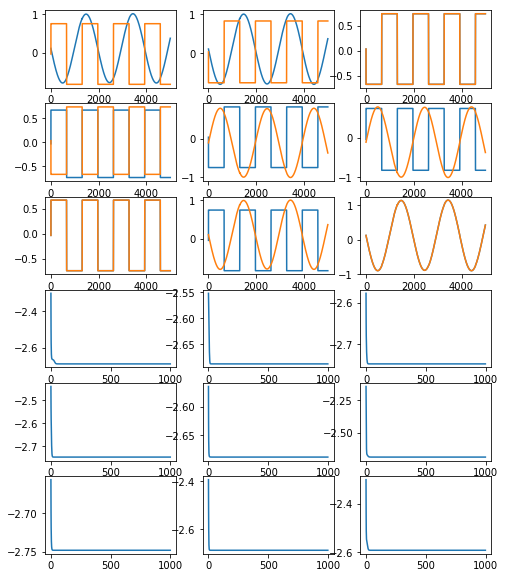

In [84]:
plt.figure(figsize=(8,10))
for i in range(9):
    plt.subplot(6,3,i+1)
    Y, W, hist_loss = ICA(X, loss_func=kurt_loss)
    plt.plot(Y.data.numpy())
    plt.subplot(6,3,i+10)
    plt.plot(hist_loss)

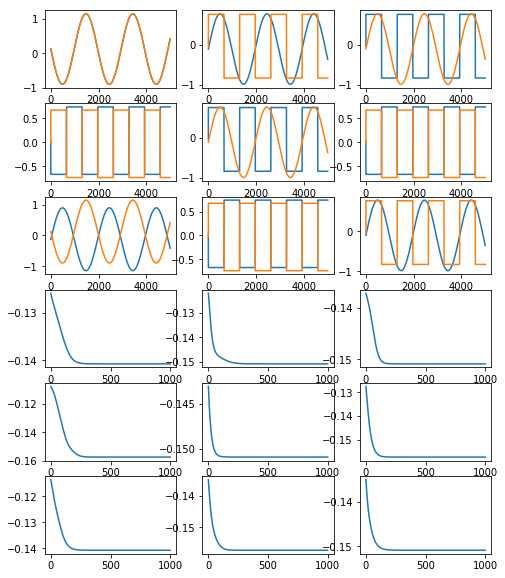

In [85]:
plt.figure(figsize=(8,10))
for i in range(9):
    plt.subplot(6,3,i+1)
    Y, W, hist_loss = ICA(X, loss_func=negentropy_loss)
    plt.plot(Y.data.numpy())
    plt.subplot(6,3,i+10)
    plt.plot(hist_loss)

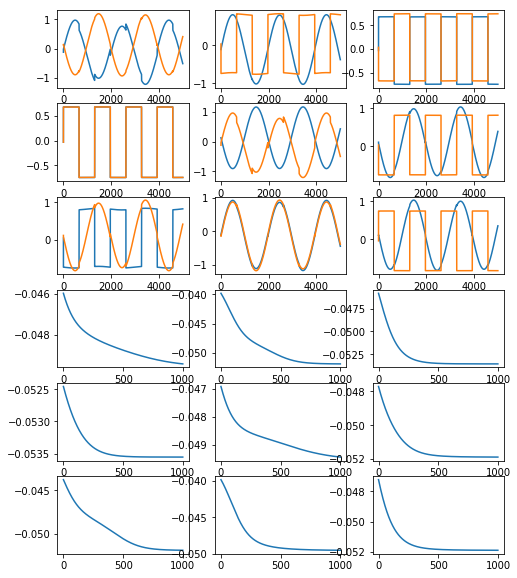

In [88]:
plt.figure(figsize=(8,10))
for i in range(9):
    plt.subplot(6,3,i+1)
    Y, W, hist_loss = ICA(X, loss_func=negentropy_loss_logcosh)
    plt.plot(Y.data.numpy())
    plt.subplot(6,3,i+10)
    plt.plot(hist_loss)

In [18]:
np.matrix(A).I

matrix([[ 1.33333333, -0.66666667],
        [-0.33333333,  0.66666667]])